# ECON 325: Introduction to Regression 
* **Authors**: COMET Team (Jonathan Graves, Jonah Heyl, Anneke Dresselhuis, Rathin Dharani, Devan Rawlings)
* **Last Update**: 12 August 2022 
---
## Outline

### Prerequisites
* Introduction to Jupyter
* Introduction to Data
* Introduction to R
* Hypothesis testing

### Outcomes

* Build a simple linear regression using R
* Create and interpret regression outputs in R including: coefficient estimates
* Examine the various elements of regression objects in R (including fitted values, residuals and coefficients)
* Explain the role of qualitative variables in regression analysis as dummy variables


In [1]:
library(tidyverse)
library(haven)

source("tests_regression.r")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘haven’ was built under R version 4.1.3”
Warning message:
“package ‘testthat’ was built under R version 4.1.3”

Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from 

In [2]:
census_data <- read_dta("../datasets/01_census2016.dta")

census_data <- as_factor(census_data)

census_data <- filter(census_data, !is.na(census_data$wages))
census_data <- filter(census_data, !is.na(census_data$mrkinc))

glimpse(census_data)

Rows: 343,063
Columns: 16
$ ppsort  <dbl> 453141, 732612, 143665, 52611, 36927, 268123, 700087, 488335, …
$ agegrp  <fct> 35 to 39 years, 40 to 44 years, 55 to 59 years, 50 to 54 years…
$ ageimm  <fct> not applicable, not applicable, not applicable, not applicable…
$ cip2011 <fct> "08 architecture, engineering, and related technologies", "06 …
$ fol     <fct> english only, english only, french only, french only, english …
$ hdgree  <fct> "certificate of apprenticeship or certificate of qualification…
$ immstat <fct> non-immigrants, non-immigrants, non-immigrants, non-immigrants…
$ kol     <fct> english only, both english and french, both english and french…
$ lfact   <fct> employed - worked in reference week, employed - worked in refe…
$ locstud <fct> ontario, ontario, prince edward island, quebec, not applicable…
$ mrkinc  <dbl> 97000, 41000, 30000, 54000, 27000, 40000, 69000, 56000, 24000,…
$ pkids   <fct> one or more, one or more, none, none, one or more, one or more…
$ pr      <fct

## Part 1: Learning About Regressions

What is a regression?  What is the relationship of a regression to other statistical concepts?  How do we use regressions to answer economic questions?

In this notebook, we will explore these questions using our census data set and will learn more about the immigrant wage gap.  If you remember from last lecture, were very interested in the relationship of `wages` and `immstat` - immigration status and wages.  However, this is not the only way to measure economic income - another variable, `mrkinc` (market income), also measures income.  Let's get started with regressions by exploring the relationship between `wages` and `mrkinc` in this dataset.

Let's start off with a visualization:



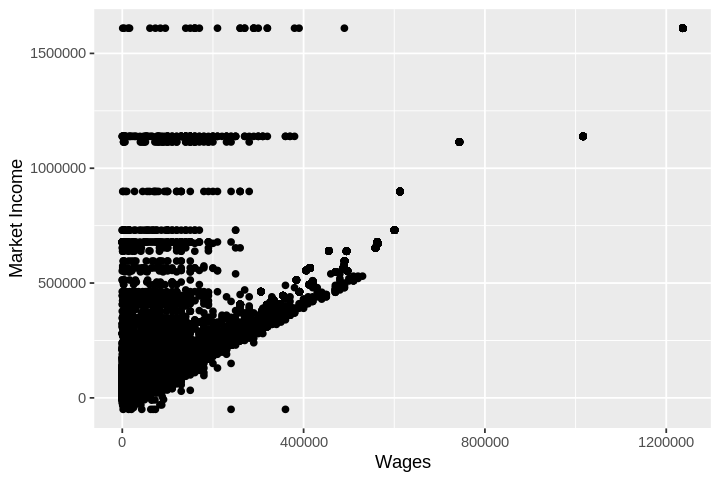

In [3]:
options(repr.plot.width=6,repr.plot.height=4) #controls the image size

f <- ggplot(data = census_data, aes(x = wages, y = mrkinc)) + xlab("Wages") + ylab("Market Income")
f + geom_point()

> _Think Deeper_: What do you see here?  Is there anything about this relationship that sticks out to you?  Why does it have the shape it does?

You can probably tell that there is definitely some relationship between wages and market income - but it can be difficult to visualize using a scatterplot alone.  There are far too many points, and too much going on.  

### Conditional Expectation:

The expectation of $X$  is what outcome we expect X to *typically* be after *a lot* of sampling. For instance, the expectation of a die throw is 3. Essentially,
$$E[X] =  \sum_{i=1}^n P(X_i=x) X_i$$

Now the conditional expectation is, 
$$E[X|y_i=y] =  \sum_{i=1}^n P(X_i=x|y_i=y) X_i$$
Linear regression assumes a linear conditional expectation function $E[Y|X=x]= \beta_0 +\beta_1X$. This is what regression models are trying to approximate. Thus we can split a regression model into two parts:
   1. the conditional exception and
   2. an error term. 
   
An example of a conditional expectation would be what number the die lands on after $n$ throws (where $n$ only counts the even throws).

### Regression Models

This is where a *regression model* comes in.  A regression model specifies (the *specification*) the relationship between two variables.  For example, a linear relationship would be:

$$M_i = \beta_0 + \beta_1 W_i$$

Where $M_i$ is the market income of individual $i$, and $W_i$ is their wage.  We normally (in econometrics) refer to $M_i$ as the **outcome** variable, and $$W_i$$ as the **explanatory** variable; you may have also heard the terms *dependent* and *independent*, but these aren't actually very good descriptions of what these variables are in econometrics.  

A model like this is our description of what this relationship is - but it depends on two unknowns: $\beta_0$, $\beta_1$. 

* The $\beta_0$ and $\beta_1$ are **parameters** of the model: they are numbers that determine the relationship (intercept and slope) between $M_i$ and $W_i$ 
* This is a linear relationship because the model we have specified is linear in the coefficients (but there are many other kinds of models).  It is also linear in the variables, but that isn't required (we will see more about this later).

However, it is unlikely, if not impossible, for this relationship to completely explain everything about our data.  We need to include a term which captures everything which is _not_ described by the relationship we described in the model.  This is called the *residual* term (meaning "leftover").

* The $\epsilon_i$ is the residual: a component that corresponds to the part of the data which is _not_ described by the model
* These residual terms will usually have certain assumed properties that allow us to estimate the model.

Conceptually, we can think about a regression as two parts: the part of the relationship explained by our model ($M_i = \beta_0 + \beta_1 W_i$) and the part which is not explained ($\epsilon_i$).  The process of "fitting" or estimating a regression model refers to the selection of values for $\beta_0$ and $\beta_1$ such that as little needs to be explained by the residual term as possible.  We write the complete *regression equation* by combining the two parts of the model:

$$M_i = \beta_0 + \beta_1 W_i + \epsilon_i$$

The goal of regression analysis is to:

1. Estimate this equation (and especially the model parameters) as accurately as possible.
2. Learn about the relationship between $M_i$ and $W_i$ from the results of that estimation.

There are many ways to define "accurately as possible" and similarly there are many ways to "estimate" the equation.  In this course, we use *ordinary least squares* (OLS) which basically says:

$$(\hat{\beta_0},\hat{\beta_1}) = \arg \min_{b_0,b_1} \sum_{i=1}^{n} (M_i - b_0 - b_1 W_i)^2 = \sum_{i=1}^{n} (e_i)^2$$

Okay, that looks complicated, but don't fear.  It is just the calculus way of writing "choose $\beta_0$ and $\beta_1$ (call them $\hat{\beta_0},\hat{\beta_1}$) such that they minimize the sum of the squared residuals".
* This should make sense; after all, the whole point of doing a regression is to explain as much as possible using the parameters ($\beta_0, \beta_1$) and as little as possible using $\epsilon_i$.
* This has transformed our statistical problem into a calculus problem, which you (well, a computer) can solve; for example, by taking derivatives.

There are many, many ways to solve this estimation problem - most of which are built into R.  You can also solve it analytically (using some math).  But let's start with an alternative. Essentially, if you remember drawing a best fit line through points from high school, this is what a linear regression does in R.

### Example: Manual Estimation

A very *bad* way to solve this is the good-'ole eyeball method.  That's right - you look at the scatterplot, then guess some values and see how it performs.

Try to get the best fit you can by playing around with the following example.


In [4]:
# set the value of B_0 and B_1 with these values

B_0 = 0  #change me
B_1 = 1  #change me

# don't touch the rest of this code - but see if you can understand it!

SSE = sum((census_data$mrkinc - B_0 - B_1*census_data$wages)^2)

# here is the SSE from your model

round(SSE/1000000,0)

[1] 553186549

What was the lowest value you got?  Here is what your guess looks like in a graph:



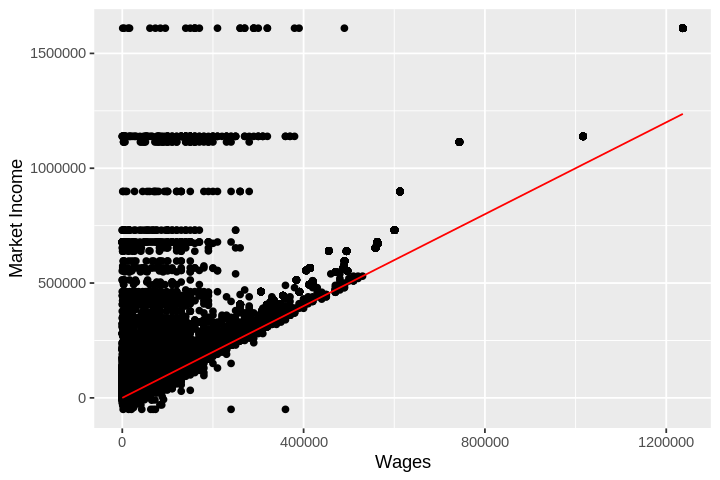

In [5]:
# just run this cell to see your results
# re-run it if you change the values

options(repr.plot.width=6,repr.plot.height=4) #controls the image size

fitted_line = data.frame(wages = census_data$wages, mrkinc = B_0 + B_1*census_data$wages)

f <- ggplot(data = census_data, aes(x = wages, y = mrkinc)) + xlab("Wages") + ylab("Market Income")
f <- f + geom_point() + geom_line(color = "red", data = fitted_line)

f

### Interactive Visualisation of OLS

Understanding OLS is absolutely fundamental to understanding regressions and further topics in econometrics. Let's try and understand the formula for OLS above through a more visual approach, just to cement our understanding. 

$$(\hat{\beta_0},\hat{\beta_1}) = \arg \min_{b_0,b_1} \sum_{i=1}^{n} (M_i - b_0 - b_1 W_i)^2 = \sum_{i=1}^{n} (e_i)^2$$

To demonstrate this, we will use a small scatter plot with just 4 points. The straight line through the scatter plot is modelled by the simple regression formula $B_0 + B_1X$. As we mentioned above, it's nearly impossible for a regression to perfectly predict the relationship between two variables, there will almost always be an associated **unobservable error** with our regression estimation. So each of the points can be modelled by the equation $Y_i = B_0 + B_1X + e_i$  This can be seen as the vertical distance between the regression line and the actual data points. You may be wondering why we can't just minimize the errors, what's the need to minimize the squared errors? You can see below that some data points are above the regression line and some are below, hence the error terms will just cancel each other out and not yield much use for us trying to find the best regression line. Therefore, we take the squares of the errors, which are depicted as the red boxes in the diagram below. Our goal is to the find the regression line that minimizes those squares of errors, hence minimize the size of those red boxes.

> Try your own values for `beta_0` and `beta_1`. Make sure to try the values only roughly within the specified range. The actual value of `beta_0` and `beta_1` that minimize the residual sum of squares is 0.65 and 0.82 respectively. The code block below also displays the area of the red boxes. You should see that deviation from these optimal values will only make the area of the red boxes larger.




[1] "Area of red boxes is: "


[1] 1.3647

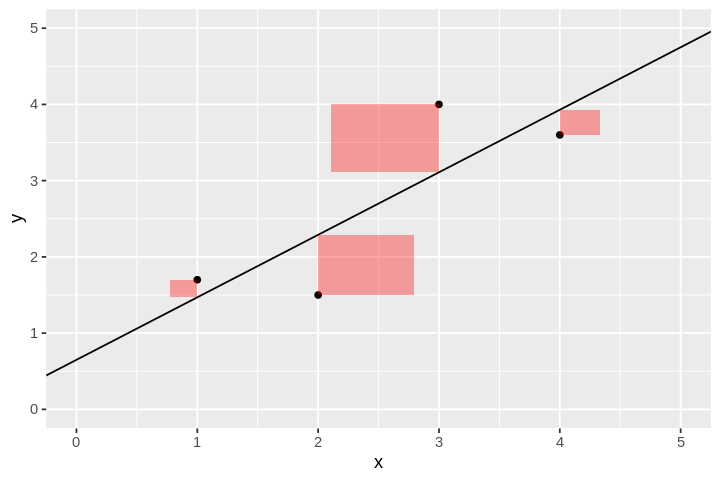

In [6]:
beta_0 <- 0.65 #CHANGE THIS VALUE, TRY VALUES BETWEEN 0 - 1
beta_1 <- 0.82 #CHANGE THIS VALUE, TRY VALUES BETWEEN 0.6 - 1.4

x <- c(1, 2, 3, 4)
y <- c(1.7, 1.5, 4, 3.6)

# don't worry about this code, just run it!
dta <- data.frame(x, y)
example_df_graph <- dta %>%
                    ggplot(aes(x = x, y = y)) +
                    geom_point() +
                    geom_abline(intercept = beta_0, slope = beta_1) +
                    xlim(0, 5) +
                    ylim(0, 5) +
                    geom_rect(aes(xmin = (dta[1, "x"] + (beta_0 + (beta_1 * dta[1, "x"])) - dta[1, "y"]), xmax = dta[1, "x"], 
                                  ymin = (beta_0 + (beta_1 * dta[1, "x"])), ymax = dta[1, "y"]),
                            alpha = 0.1,
                            fill = "red") +
                    geom_rect(aes(xmin = dta[2, "x"], xmax = (dta[2, "x"] + (beta_0 + (beta_1 * dta[2, "x"])) - dta[2, "y"]), 
                                  ymin = dta[2, "y"], ymax = (beta_0 + (beta_1 * dta[2, "x"]))), 
                            alpha = 0.1, 
                            fill = "red") +
                    geom_rect(aes(xmin = (dta[3, "x"] + (beta_0 + (beta_1 * dta[3, "x"])) - dta[3, "y"]), xmax = dta[3, "x"], 
                                  ymin = (beta_0 + (beta_1 * dta[3, "x"])), ymax = dta[3, "y"]), 
                            alpha = 0.1, 
                            fill = "red") +
                    geom_rect(aes(xmin = dta[4, "x"], xmax = (dta[4, "x"] + (beta_0 + (beta_1 * dta[4, "x"])) - dta[4, "y"]), 
                                  ymin = dta[4, "y"], ymax = (beta_0 + (beta_1 * dta[4, "x"]))), 
                            alpha = 0.1, 
                            fill = "red")
example_df_graph

area_1 <- ((dta[1, "x"] - (dta[1, "x"] + (beta_0 + (beta_1 * dta[1, "x"])) - dta[1, "y"])) * 
        ((beta_0 + (beta_1 * dta[2, "x"])) - dta[2, "y"]))
area_2 <- ((dta[2, "x"] + (beta_0 + (beta_1 * dta[2, "x"])) - dta[2, "y"]) - dta[2, "x"]) * 
          ((beta_0 + (beta_1 * dta[2, "x"])) - dta[2, "y"])
area_3 <- (dta[3, "x"] - (dta[3, "x"] + (beta_0 + (beta_1 * dta[3, "x"])) - dta[3, "y"])) * 
          (dta[3, "y"]) - (beta_0 + (beta_1 * dta[3, "x"]))
area_4 <- ((dta[4, "x"] + (beta_0 + (beta_1 * dta[4, "x"])) - dta[4, "y"]) - dta[4, "x"]) * 
          ((beta_0 + (beta_1 * dta[4, "x"])) - dta[4, "y"])

area <- area_1 + area_2 + area_3 + area_4
print("Area of red boxes is: ")
area

## Simple Regressions in R

Now, let's see how we could use a regression in R to do this.  The main part of a regression model in R is the... model.  Not very surprising!  Regression models look like: `Y ~ X` (the `~` symbol is called "tilde" FYI). `Y ~ X` means that we have created a model where `Y` is regressed on `X`.

We can ignore the residual terms and parameters when writing the model in R and just focus on the variables for now.

So, for example, our regression model is 

$$M_i = \beta_0 + \beta_1 W_i + \epsilon_i$$

Which can be written in R as

`mrkinc ~ wages`

Regressions are estimated in R using the `lm` function, which takes the data as an argument.
* This create a _linear model_ object, which can be used to calculate things (using prediction) or perform tests
* It also stores all of the information about the model, such as the coefficient and fit
* These models can also be printed and summarized to give important basic information about a regression

Some of the most important elements of a linear model (for example, suppose you called the model ``my_model``) are:

* ``my_model$coefficients``: the parameter coefficients
* ``my_model$residuals``: the residuals
* ``my_model$fitted.values``: the predicted values

Enough talk! Let's see our model in action here.


In [ ]:
regression1 = lm(mrkinc ~ wages, data = census_data)

summary(regression1)

head(regression1$coefficients)

Take a close look at the results.  Identify the following elements:

* The values of the parameters 
* The standard errors of the parameters
* The %-of the data explained by the model (R-sqaured)

> **Test Your Knowledge**: What  %-of the data is explained by the model?  Answer to 2 decimal places.



In [ ]:
answer1 <- # answer goes here

test_1()

The underlying model and the parameters tell us about the relationship between the different values:

$$M_i = -2,464 + 1.61 W_i + \epsilon_i$$

Notice, for example:

$$\frac{\partial M_i}{\partial W_i} = \beta_1 = 1.61$$

In other words, when wages go up by 1 dollar, we would expect that market income will rise by 1.61 dollars.  This kind of analysis is key to *interpreting* what this model is telling us.

Finally, let's visualize our fitted model on the scatterplot from before.  How does it compare to your original model?

In [ ]:
fitted_line2 = data.frame(wages = census_data$wages, mrkinc = regression1$fitted.values)

f <- ggplot(data = census_data, aes(x = wages, y = mrkinc)) + xlab("Wages") + ylab("Market Income")
f <- f + geom_point() + geom_line(color = "red", data = fitted_line) + geom_line(color = "blue", data = fitted_line2)

f

As you can see - there's a very close relationship between ``mrkinc`` and ``wages``.  This implies that we can focus our attention on wages in our analysis of the immigrant wage gap.

## Part 2: Simple Regressions and $t$-Tests

Previously, we looked at the relationship between market income and wages.  However, these are both _quantitative_ variables.  However, what if we wanted to work with a _qualitative_ variable like ``immstat``?

Regression models can still incorporate this kind of variable - which is good, because (as the Census makes clear) this is the most common type of variable in real-world data.  How is this possible?  

Let's start out with the simplest kind of qualitative variable: a **dummy** (0 or 1) variable.  Consider the regression equation:

$$W_i = \beta_0 + \beta_1 I_i + \epsilon_i$$

Consider the conditional expectation:

$$E[W_i|I_i = 1] = \beta_0 + \beta_1 \cdot 1 + E[\epsilon_i|I_i = 1]$$

$$E[W_i|I_i = 0] = \beta_0 + \beta_1 \cdot 0 + E[\epsilon_i|I_i = 0]$$


Under Assumption 1, we have that $E[\epsilon_i|I_i] = 0$, so:

$$E[W_i|I_i = 1] = \beta_0 + \beta_1$$

$$E[W_i|I_i = 0] = \beta_0$$

Combining these two expressions:

$$\beta_1 = E[W_i|I_i = 1] - E[W_i|I_i = 0]$$

What this tells us:

1.  You can include **dummy** variables in regressions
2.  The coefficients on the dummy variable have meaning in terms of the regression model
3.  They measure the (average) difference in the dependent variable between the two levels of the dummy variable

It is important to keep this in mind, since in terms of using regression models, what this tells us is that dummy variables can be included in a regression model just like quantitative variables.

Let's look at this in terms of ``immstat``.  We can create our regression equation as:

$$W_i = \beta_0 + \beta_1 I_i + \epsilon_i$$

Then we can estimate this using R.


In [ ]:
regression2 <- lm(wages ~ immstat, data = census_data)

summary(regression2)

What do you see here?

> **Test Your Knowledge**:  What is the difference in average wage between immigrants and non-immigrants?

In [ ]:
#input the answer (to 1 decimal place)
answer2 <- ###? 

test_2()

The number about might seem familiar, if you remember what we learned about a $t$-test from earlier.  Remember this result?

In [ ]:
t1 <- t.test(x = filter(census_data, immstat == "immigrants")$wages,
       y = filter(census_data, immstat == "non-immigrants")$wages,
       alternative = "two.sided",
       mu = 0,
       conf.level = 0.95)
t1

t1$estimate[1] - t1$estimate[2]

Look closely at this result, and the result above.  What do you see?  What is the relationship here.


This is a very important result: regression is an example of the comparison that a two sample comparison is making, when the explantory variable is a dummy.  Why is this?  Recall:

$$\beta_1 = E[W_i|I_i = 1] - E[W_i|I_i = 0]$$

The regression coefficient of $\beta_1$ has the interpretation of being a comparison of two means.  This is exactly the same as what the $t$-test is doing!  Comparing two means by different groups - groups which are specified by $I_i = 0$ or $I_i = 1$.

* In other words, another way of thinking about a regression is like a form of ``super'' comparison of means test.
* It can handle the same kind of analysis (i.e. with dummies), but also include quantitative variables, which regular comparison of means tests cannot handle.

## Part 3: Exercises

### Activity 1
Last week, we briefly explored the idea that the immigrant wage gap could depend on sex (male vs. female). We can now examine this issue directly using regressions.

Estimate the immigrant wage gap for males and for females using regressions. 

<em>Tested objects:</em> ``regm`` (the regression for males), ``regf`` (the regression for females).

In [ ]:
#Quiz 1

#Regression for males
regm <- lm(??? ~ ???, data = filter(census_data, ??? == ???)) #what should replace the ???

#Regression for females
regf <-  #what should replace the ???

summary(regm) #Allow us to view regm's coefficient estimates
summary(regf) #Same as above, but for regf

test_3() #Quiz1
test_4() #Quiz2

#### Short Answer 1
**Prompt:** How do we interpret the coefficient (Intercept) estimate on `immstat` in each of these regressions?

**A** The average wage of a non-immigrant   
**B** The average wage of an immigrant  
**C** The difference between the average wage of an immigrant and non-immigrant  
**D** Nothing we should worry about  



In [ ]:
## ENTER YOUR ANSWER BELOW AS "A", "B", "C", or "D"

answer20 <- ""
test_20(answer20)

#### Short Answer 2
**Prompt:** Compare the gaps. Is the immigrant wage gap larger for males or females? Why do you think that might that be?

**A** The immigrant pay gap for females is much greater than that of males  
**B** The immigrant pay gap for males is much greater than that of females  
**C** The immigrant pay gap is roughly the same  

In [ ]:
## ENTER YOUR ANSWER BELOW AS "A", "B", or "C"

answer21 <- ""
test_21(answer21)

### Activity 2
Many studies have suggested that workers' wages increase as they age. In this activity, we will explore how the immigrant wage gap varies by age. First, let's see the factor levels of the ``agegrp``:

In [ ]:
levels(census_data$agegrp) #Run this!

As we can see, there are several age groups in this dataframe, including ones that would not be particularly informative (have you ever seen a 3- year-old doing salary work?). Let's estimate the immigrant wage gap (with no controls) for five of these groups separately:
* 20 to 24 years
* 30 to 34 years
* 40 to 44 years
* 50 to 54 years
* 60 to 64 years

<em>Tested objects:</em> ``reg5_20`` (20 to 24 years), ``reg5_50`` (50 to 54 years)

In [ ]:
reg5_20 <- lm(wages ~ immstat, data = filter(census_data, agegrp == '20 to 24 years')) #what should replace the ???

reg5_30 <-  #what should go here?  use the above

reg5_40 <- 

reg5_50 <- 

reg5_60 <- 

# store the summaries (but don't show them!  too many!)
sum20 <- summary(reg5_20)
sum30 <- summary(reg5_30)
sum40 <- summary(reg5_40)
sum50 <- summary(reg5_50)
sum60 <- summary(reg5_60)


test_12() #Quiz3
test_16() #Quiz4

The code below will tabulate a brief summary of each regression:

In [ ]:
# just run me!  You don't need to edit this

Age_Group <- c("20-24", "30-34", "40-44", "50-54", "60-64")
Wage_Gap <- c(reg5_20$coefficients[2], reg5_30$coefficients[2], reg5_40$coefficients[2], reg5_50$coefficients[2], reg5_60$coefficients[2])
Std._Error <- c(sum20$coefficients[2,2], sum30$coefficients[2,2], sum40$coefficients[2,2], sum50$coefficients[2,2], sum60$coefficients[2,2])
t_Value <- c(sum20$coefficients[2,3], sum30$coefficients[2,3], sum40$coefficients[2,3], sum50$coefficients[2,3], sum60$coefficients[2,3])
p_Value <- c(sum20$coefficients[2,4], sum30$coefficients[2,4], sum40$coefficients[2,4], sum50$coefficients[2,4], sum60$coefficients[2,4])

tibble(Age_Group, Wage_Gap, Std._Error, t_Value, p_Value) #it's like a table but a tibble

#### Short Answer 3
**Prompt**: What happens to the immigrant wage gap as we move across age groups? What do you think might explain these changes?

**A** Wage gap declines as age group decreases  
**B** Wage gap increases as age group increases  
**C** Wage gap is the highest at the "40 to 44 years" age group  


In [ ]:
#### ENTER YOUR ANSWER BELOW AS "A", "B", or "C"

answer22 <- ""
test_22(answer22)

### Activity 3
As we observed in last week's worksheet, the immigrant wage gap could differ by education level. Since there are many education categories, however, we may not want to examine this by running a regression for each education level separately. 

Instead, we could run a single regression and add education level as a second regressor, $E_i$: 

$$W_i = \beta_0 + \beta_1 I_i + \beta_2 E_i + \epsilon_i$$

This is actually a **multiple regression**, which we will learn about next week - but from the point of the this lesson, the idea is that it is "run" in R essentially in the same way as a simple regression.  Estimate the regression model above without $E_i$, then re-estimate the model with $E_i$ added.

<em>Tested objects:</em> ``reg2A`` (regression without controls), ``reg2B`` (regression with controls).

In [ ]:
#Naive regression (just immstat)
reg2A <- lm(??? ~ ???, data = census_data) #this one works already

#Regression with controls
reg2B <-  lm(??? ~ immstat + ???, data = census_data) #what should replace the ??? think about the model


summary(reg2A)
summary(reg2B)
#this will look ugly; try to look carefully at the output

test_7()
test_8() #Quiz 5

#### Short Answer 4
**Prompt** Compare the estimated immigrant wage gap with and without $E_i$ in the regression. What happens to the gap when we add $E_i$? How do we interpret this?

**A** The estimated immigrant wage gap has increased after adding controls  
**B** The estimated immigrant wage gap has decreased after adding controls  
**C** The estimated immigrant wage gap has not changed after adding controls  

In [ ]:
#### ENTER YOUR ANSWER BELOW AS "A", "B", or "C"

answer23 <- ""
test_23(answer23)

### Activity 4

Another topic of interest for labor economists that is related to the immigrant wage gap is racial wage discrimination -- the issue of workers of similar productivity being paid different wages on average because of their race. Consequently, we can also use regressions to estimate the racial wage gap.

Let's suppose that we want to estimate this racial wage gap. Run a regression (without controls) that does this.

<em>Test objects:</em> ``reg_race``.

In [ ]:
##Do not modify this line (sets "not a visible minority" as the reference level):
census_data$vismin <- relevel(census_data$vismin, ref = "not a visible minority")
#this is also how you set a different base level for a factor (handy!)

##Racial Wage Gap Regression

reg_race <- lm(wages ~ ???, data = census_data) #what model should we use here?

summary(reg_race)

test_10() #Quiz6

#### Short Answer 5
**Prompt**: How should we interpret the regression estimate for `visminblack`?

**A** People from the black community make on average about 14,795 dollars less as compared to an average white person.  
**B** Black immigrants make 14,795 dollars less than Black non-immigrants on average  
**C** On average, a person from the black community makes 14,795 dollars less than an average white person, holding all other variables constant  

In [ ]:
#### ENTER YOUR ANSWER BELOW AS "A", "B", or "C"

answer24 <- ""
test_24(answer24)

#### Short Answer 6
**Prompt**: With this racial wage gap in mind, let's return to the immigrant wage gap. Should we add explanatory variables for race to our regression from activity 2 and 3? Why or why not?

**A** No we should not  
**B** Yes, we should because there could be other factors explaining the wage gap  
**C** Yes, we should control for education and that's it.    
**D** Yes, we should control for immigrant status and that's it.  

In [ ]:
#### ENTER YOUR ANSWER BELOW AS "A", "B", or "C"

answer25 <- ""
test_25(answer25)

<font style="color:red">Answer in red here!</font>

#### Theoretical Answer 2

In your answer above, what would happen if you went from  What about when $I_i = 1$ to $I_i = 0$?  Is it the same as before?  Explain why or why not.

<font style="color:red">Answer in red here!</font>